[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1jGVvKlJfUX2_uMuLN6n0SRF8U-h8akLA?usp=sharing)

# Treinamento e validação de modelos no TFX

Nesse notebook iremos criar e executar um Pipeline do TFX para treinar e validar um modelo.

## Introdução

### Motivação

Fizemos um modelo. Como podemos servi-lo de forma confiável para gere valor para a empresa? E como podemos prepara-lo para isso de forma automática com TFx?

### Pipeline que iremos construir

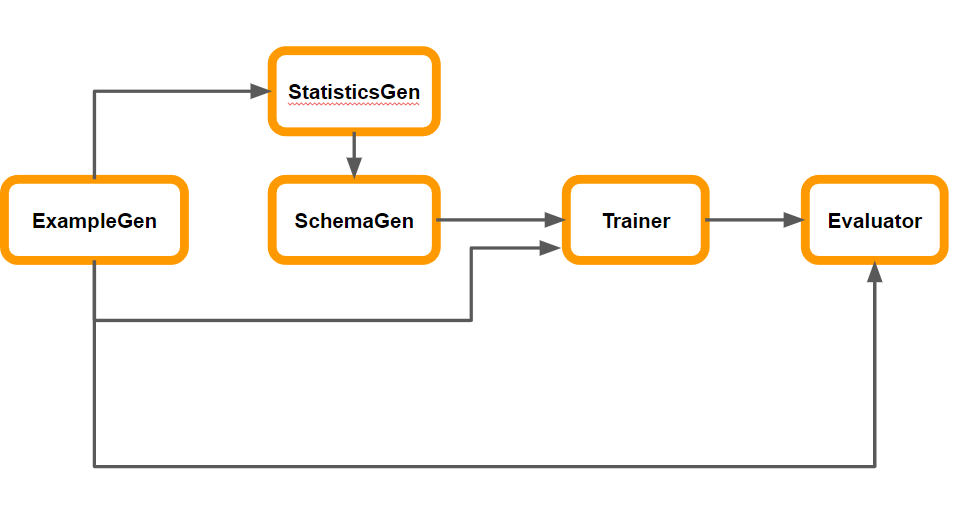

## Execução

### Configuração do ambiente

In [ ]:
# Garantir que temos a biblioteca colab e que o pip está atualizado
try:
  import colab
  !pip install --upgrade pip
except:
  pass

In [ ]:
# Instalando TFX
!pip install -U tfx --quiet

Após a instalação, reinicie seu ambiente para garantir que o Colab veja o TFX. Para isso, clique em "Ambiente de execução" $\rightarrow$ "Reiniciar ambiente de execução".

Feito isso, comece a executar a partir da próxima célula.

In [ ]:
from tfx import v1 as tfx
print('TFX version: {}'.format(tfx.__version__))

### Utils

In [ ]:
from ml_metadata.proto import metadata_store_pb2
# Non-public APIs, just for showcase.
from tfx.orchestration.portable.mlmd import execution_lib

# TODO(b/171447278): Move these functions into the TFX library.

def get_latest_artifacts(metadata, pipeline_name, component_id):
  """Output artifacts of the latest run of the component."""
  context = metadata.store.get_context_by_type_and_name(
      'node', f'{pipeline_name}.{component_id}')
  executions = metadata.store.get_executions_by_context(context.id)
  latest_execution = max(executions,
                         key=lambda e:e.last_update_time_since_epoch)
  return execution_lib.get_artifacts_dict(metadata, latest_execution.id,
                                          [metadata_store_pb2.Event.OUTPUT])

# Non-public APIs, just for showcase.
from tfx.orchestration.experimental.interactive import visualizations

def visualize_artifacts(artifacts):
  """Visualizes artifacts using standard visualization modules."""
  for artifact in artifacts:
    visualization = visualizations.get_registry().get_visualization(
        artifact.type_name)
    print(visualization)
    if visualization:
      visualization.display(artifact)

from tfx.orchestration.experimental.interactive import standard_visualizations
standard_visualizations.register_standard_visualizations()

### Iniciando nosso experimento

In [ ]:
import os

# Vamos definir os nomes dos nossos pipelines para definirmos
# as pastas onde iremos salvas os artefatos gerados
PIPELINE = "iris"

# Pastas onde iremos salvar os outputs
PIPELINE_ROOT = os.path.join('pipelines', PIPELINE)

# Caminho para o banco de dados SQLite que usaremos como nosso banco de metadata
METADATA_PIPELINE_PATH = os.path.join('metadata', PIPELINE, 'metadata.db')

#### Preparando os dados



In [ ]:
import urllib.request
import tempfile

DATA_ROOT = tempfile.mkdtemp(prefix='tfx-data')  # Criando pasta temporária
_data_url = 'https://forge.scilab.org/index.php/p/rdataset/source/file/master/csv/datasets/iris.csv'
_data_filepath = os.path.join(DATA_ROOT, "data.csv")
urllib.request.urlretrieve(_data_url, _data_filepath)

In [ ]:
import pandas as pd

df = pd.read_csv(_data_filepath, index_col=0)
df.head()

In [ ]:
!mkdir data
!mkdir data/train
!mkdir data/eval

In [ ]:
df.to_csv('data/iris.csv', index = False)
df['Species'] = df['Species'].map({'setosa': 0, 'versicolor': 1, 'virginica': 2})
df = df.sample(frac=1)
df_train = df.iloc[:100]
df_eval  = df.iloc[100:]
df_train.to_csv('data/train/iris_train.csv', index = False)
df_eval.to_csv('data/eval/iris_eval.csv', index = False)

### Pipeline da aula passada: Transform

In [ ]:
from tfx.proto import example_gen_pb2
from tfx.v1.proto import Input

In [ ]:
_module_file = 'preprocessing.py'

In [ ]:
%%writefile {_module_file}

import tensorflow as tf
import tensorflow_transform as tft

# Essa será a funcao chamada pelo Transform
def preprocessing_fn(inputs):
  """tf.transform's callback function for preprocessing inputs.

  Args:
    inputs: map from feature keys to raw not-yet-transformed features.

  Returns:
    Map from string feature key to transformed feature.
  """
  outputs = {}
  outputs['Sepal.Length'] = tft.scale_by_min_max(inputs['Sepal.Length'])
  outputs['Sepal.Width'] = tft.scale_by_min_max(inputs['Sepal.Width'])
  outputs['Petal.Length'] = tft.scale_by_min_max(inputs['Petal.Length'])
  outputs['Petal.Width'] = tft.scale_by_min_max(inputs['Petal.Width'])
  outputs['Species'] = inputs['Species']
  return outputs

In [ ]:
def _create_transform_pipeline(pipeline_name: str,
                            pipeline_root: str,
                            data_root: str,
                            metadata_path: str) -> tfx.dsl.Pipeline:
  """Creates a pipeline for schema generation."""
  # Ingestão de dados
  input = Input(splits=[
                example_gen_pb2.Input.Split(name='train', pattern='train/*'),
                example_gen_pb2.Input.Split(name='eval', pattern='eval/*')
            ])
  example_gen = tfx.components.CsvExampleGen(input_base=data_root, input_config=input)

  # Computa as estatísticas para visualização e geração do schema
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])

  # Gera o schema baseado nas estatísticas
  schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)

  transform = tfx.components.Transform(
      examples=example_gen.outputs['examples'],
      schema=schema_gen.outputs['schema'],
      materialize=True,
      module_file=_module_file)

  components = [
      example_gen,
      statistics_gen,
      schema_gen,
      transform
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

In [ ]:
tfx.orchestration.LocalDagRunner().run(
  _create_transform_pipeline(
      pipeline_name=PIPELINE,
      pipeline_root=PIPELINE_ROOT,
      data_root='data',
      metadata_path=METADATA_PIPELINE_PATH))

### Pipeline com treinamento: Explicando o componente Trainer

O componente Trainer é quem de fato executa o treinamento. Ele recebe como input:

- um arquivo .py com uma função *run_fn()* definida nessa arquivo, a qual será o ponto de entrada para iniciar o treinamento do modelo;
- os exemplos transformados gerados como saída do Transform;
- o grafo de operações gerado como saída do Transform;
- o schema gerado pelo componente SchemaGen ou pelo Transform;
- número de steps por época.

In [ ]:
_trainer_module_file = 'iris_trainer.py'

In [ ]:
%%writefile {_trainer_module_file}

# Copied from https://www.tensorflow.org/tfx/tutorials/tfx/penguin_simple

from typing import List
from absl import logging
import tensorflow as tf
from tensorflow import keras
from tensorflow_transform.tf_metadata import schema_utils

from tfx import v1 as tfx
from tfx_bsl.public import tfxio
from tensorflow_metadata.proto.v0 import schema_pb2

_LABEL_KEY = 'Species'

_TRAIN_BATCH_SIZE = 100
_EVAL_BATCH_SIZE = 50

def _input_fn(file_pattern: List[str],
              data_accessor: tfx.components.DataAccessor,
              schema: schema_pb2.Schema,
              batch_size: int) -> tf.data.Dataset:
  """Generates features and label for training.

  Args:
    file_pattern: List of paths or patterns of input tfrecord files.
    data_accessor: DataAccessor for converting input to RecordBatch.
    schema: schema of the input data.
    batch_size: representing the number of consecutive elements of returned
      dataset to combine in a single batch

  Returns:
    A dataset that contains (features, indices) tuple where features is a
      dictionary of Tensors, and indices is a single Tensor of label indices.
  """
  return data_accessor.tf_dataset_factory(
      file_pattern,
      tfxio.TensorFlowDatasetOptions(
          batch_size=batch_size, label_key=_LABEL_KEY),
      schema=schema).repeat()


def _make_keras_model(schema: schema_pb2.Schema) -> tf.keras.Model:
  """Creates a DNN Keras model for classifying iris data.

  Returns:
    A Keras Model.
  """
  feature_keys = [f.name for f in schema.feature if f.name != _LABEL_KEY]
  inputs = [keras.layers.Input(shape=(1,), name=f) for f in feature_keys]
  d = keras.layers.concatenate(inputs)
  for _ in range(2):
    d = keras.layers.Dense(10, activation='linear')(d)
  outputs = keras.layers.Dense(3)(d)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(
      optimizer=keras.optimizers.Adam(1e-2),
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      metrics=[keras.metrics.SparseCategoricalAccuracy()])

  model.summary(print_fn=logging.info)
  return model


# TFX Trainer will call this function.
def run_fn(fn_args: tfx.components.FnArgs):
  """Train the model based on given args.

  Args:
    fn_args: Holds args used to train the model as name/value pairs.
  """
  schema = tfx.utils.parse_pbtxt_file(fn_args.schema_path, schema_pb2.Schema())

  train_dataset = _input_fn(
      fn_args.train_files,
      fn_args.data_accessor,
      schema,
      batch_size=_TRAIN_BATCH_SIZE)
  eval_dataset = _input_fn(
      fn_args.eval_files,
      fn_args.data_accessor,
      schema,
      batch_size=_EVAL_BATCH_SIZE)

  model = _make_keras_model(schema)

  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=fn_args.model_run_dir, update_freq='batch')

  model.fit(
      train_dataset,
      epochs=20,
      steps_per_epoch=fn_args.train_steps,
      validation_data=eval_dataset,
      validation_steps=fn_args.eval_steps,
      callbacks=[tensorboard_callback])

  # The result of the training should be saved in `fn_args.serving_model_dir`
  # directory.
  model.save(fn_args.serving_model_dir, save_format='tf')

In [ ]:
def _create_trainer_pipeline(pipeline_name: str,
                            pipeline_root: str,
                            data_root: str,
                            metadata_path: str) -> tfx.dsl.Pipeline:
  """Creates a pipeline for schema generation."""
  # Ingestão de dados
  input = Input(splits=[
                example_gen_pb2.Input.Split(name='train', pattern='train/*'),
                example_gen_pb2.Input.Split(name='eval', pattern='eval/*')
            ])
  example_gen = tfx.components.CsvExampleGen(input_base=data_root, input_config=input)

  # Computa as estatísticas para visualização e geração do schema
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])

  # Gera o schema baseado nas estatísticas
  schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)
  
  trainer = tfx.components.Trainer(
    module_file=os.path.abspath(_trainer_module_file),
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    train_args=tfx.proto.TrainArgs(num_steps=1),
    eval_args=tfx.proto.EvalArgs(num_steps=1))

  components = [
      example_gen,
      statistics_gen,
      schema_gen,
      trainer
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

In [ ]:
tfx.orchestration.LocalDagRunner().run(
  _create_trainer_pipeline(
      pipeline_name=PIPELINE,
      pipeline_root=PIPELINE_ROOT,
      data_root='data',
      metadata_path=METADATA_PIPELINE_PATH))

In [ ]:
from tfx.orchestration.metadata import Metadata
from tfx.types import standard_component_specs

# Conectando ao banco de dados de metadata
metadata_connection_config = tfx.orchestration.metadata.sqlite_metadata_connection_config(
    METADATA_PIPELINE_PATH)

with Metadata(metadata_connection_config) as metadata_handler:
  
  # Pegando a ultima execução do StatisticsGen
  trainer_output = get_latest_artifacts(metadata_handler, PIPELINE,
                                         'Trainer')
  model_run_artifacts = trainer_output[standard_component_specs.MODEL_RUN_KEY]

In [ ]:
model_run_artifact_dir = model_run_artifacts[0].uri

%reload_ext tensorboard
%tensorboard --logdir {model_run_artifact_dir}

### Pipeline com validação de modelo: Explicando o componente Evaluator

O componente Evaluator faz uso da biblioteca TFMA para avaliação as predições do modelo no dataset de validação. Ele usa como entrada:

- a saída do componente ExampleGen (os exemplos);
- a saída do componente Trainer (o modelo);
- arquivo de configuração definido pelo usuário.

In [ ]:
import tensorflow_model_analysis as tfma

eval_config = tfma.EvalConfig(
    model_specs=[
        tfma.ModelSpec(label_key='Species')
        ],
    slicing_specs=[tfma.SlicingSpec()],
    metrics_specs=[
                   tfma.MetricsSpec(metrics=[
                      tfma.MetricConfig(class_name='ExampleCount'),
                   ])
    ]
    )

In [ ]:
def _create_evaluator_pipeline(pipeline_name: str,
                            pipeline_root: str,
                            data_root: str,
                            metadata_path: str) -> tfx.dsl.Pipeline:
  """Creates a pipeline for schema generation."""
  # Ingestão de dados
  # Ingestão de dados
  input = Input(splits=[
                example_gen_pb2.Input.Split(name='train', pattern='train/*'),
                example_gen_pb2.Input.Split(name='eval', pattern='eval/*')
            ])
  example_gen = tfx.components.CsvExampleGen(input_base=data_root, input_config=input)

  # Computa as estatísticas para visualização e geração do schema
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])

  # Gera o schema baseado nas estatísticas
  schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)
  
  trainer = tfx.components.Trainer(
    module_file=os.path.abspath(_trainer_module_file),
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    train_args=tfx.proto.TrainArgs(num_steps=1),
    eval_args=tfx.proto.EvalArgs(num_steps=1))

  evaluator = tfx.components.Evaluator(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    eval_config=eval_config)

  components = [
      example_gen,
      statistics_gen,
      schema_gen,
      trainer,
      evaluator
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

In [ ]:
tfx.orchestration.LocalDagRunner().run(
  _create_evaluator_pipeline(
      pipeline_name=PIPELINE,
      pipeline_root=PIPELINE_ROOT,
      data_root='data',
      metadata_path=METADATA_PIPELINE_PATH))

In [ ]:
from tfx.orchestration.metadata import Metadata
from tfx.types import standard_component_specs

# Conectando ao banco de dados de metadata
metadata_connection_config = tfx.orchestration.metadata.sqlite_metadata_connection_config(
    METADATA_PIPELINE_PATH)

with Metadata(metadata_connection_config) as metadata_handler:
  
  # Pegando a ultima execução do StatisticsGen
  evaluator_output = get_latest_artifacts(metadata_handler, PIPELINE,
                                         'Evaluator')
  trainer_output = get_latest_artifacts(metadata_handler, PIPELINE,
                                         'Trainer')
  evaluation_artifacts = evaluator_output[standard_component_specs.EVALUATION_KEY]
  trainer_artifacts = trainer_output[standard_component_specs.MODEL_KEY]

In [ ]:
visualize_artifacts(evaluation_artifacts)

### Pipeline com validação de modelo: Explicando o componente Pusher

O componente Pusher copia o modelo salvo para um diretório apontado nos parâmetros como `push_destination`. Pode ou não depender de blessings, que são outputs dados pelos compontentes de validação. Neste notebook, usaremos o blessing do `Evaluator`.

Recebe como parâmetros:

- a saída do componente Trainer (o modelo);
- Um destino (bucket ou path de filesystem);
- Eventualmente blessings de outros componentes.

In [ ]:
def _create_pusher_pipeline(pipeline_name: str,
                            pipeline_root: str,
                            data_root: str,
                            metadata_path: str) -> tfx.dsl.Pipeline:
  """Creates a pipeline for schema generation."""
  # Ingestão de dados
  # Ingestão de dados
  input = Input(splits=[
                example_gen_pb2.Input.Split(name='train', pattern='train/*'),
                example_gen_pb2.Input.Split(name='eval', pattern='eval/*')
            ])
  example_gen = tfx.components.CsvExampleGen(input_base=data_root, input_config=input)

  # Computa as estatísticas para visualização e geração do schema
  statistics_gen = tfx.components.StatisticsGen(
      examples=example_gen.outputs['examples'])

  # Gera o schema baseado nas estatísticas
  schema_gen = tfx.components.SchemaGen(
      statistics=statistics_gen.outputs['statistics'], infer_feature_shape=True)
  
  trainer = tfx.components.Trainer(
    module_file=os.path.abspath(_trainer_module_file),
    examples=example_gen.outputs['examples'],
    schema=schema_gen.outputs['schema'],
    train_args=tfx.proto.TrainArgs(num_steps=1),
    eval_args=tfx.proto.EvalArgs(num_steps=1))

  evaluator = tfx.components.Evaluator(
    examples=example_gen.outputs['examples'],
    model=trainer.outputs['model'],
    eval_config=eval_config)

  pusher = tfx.components.Pusher(
      model=trainer.outputs['model'],
      # model_blessing=evaluator.outputs['blessing'],
      push_destination=tfx.proto.PushDestination(
          filesystem=tfx.proto.PushDestination.Filesystem(
              base_directory="/content/models-to-serve/iris-model"))
    )

  components = [
      example_gen,
      statistics_gen,
      schema_gen,
      trainer,
      evaluator,
      pusher
  ]

  return tfx.dsl.Pipeline(
      pipeline_name=pipeline_name,
      pipeline_root=pipeline_root,
      metadata_connection_config=tfx.orchestration.metadata
      .sqlite_metadata_connection_config(metadata_path),
      components=components)

In [ ]:
tfx.orchestration.LocalDagRunner().run(
  _create_pusher_pipeline(
      pipeline_name=PIPELINE,
      pipeline_root=PIPELINE_ROOT,
      data_root='data',
      metadata_path=METADATA_PIPELINE_PATH))

In [ ]:
from tfx.orchestration.metadata import Metadata
from tfx.types import standard_component_specs

# Conectando ao banco de dados de metadata
metadata_connection_config = tfx.orchestration.metadata.sqlite_metadata_connection_config(
    METADATA_PIPELINE_PATH)

with Metadata(metadata_connection_config) as metadata_handler:
  
  # Pegando a ultima execução do StatisticsGen
  evaluator_output = get_latest_artifacts(metadata_handler, PIPELINE,
                                         'Evaluator')
  trainer_output = get_latest_artifacts(metadata_handler, PIPELINE,
                                         'Trainer')
  evaluation_artifacts = evaluator_output[standard_component_specs.EVALUATION_KEY]
  trainer_artifacts = trainer_output[standard_component_specs.MODEL_KEY]
  
  pusher_output = get_latest_artifacts(metadata_handler, PIPELINE,
                                      'Pusher')
  
  pusher_artifacts = pusher_output[standard_component_specs.PUSHED_MODEL_KEY]

In [ ]:
pusher_artifacts[0]

In [ ]:
pushed_model_uri = pusher_artifacts[0].get_custom_property("pushed_destination")

In [ ]:
print(pushed_model_uri)

### Validando o modelo que treinamos e conferindo o resultado

In [ ]:
from tensorflow import keras
import tensorflow as tf
model = keras.models.load_model(pushed_model_uri)

In [ ]:
preds = model(list(df_eval.drop(columns=['Species'])[['Petal.Length', 'Petal.Width', 'Sepal.Length', 'Sepal.Width']].values.T)).numpy().argmax(axis=1)

In [ ]:
target = df_eval.Species.values

In [ ]:
(preds == target).mean()

### Servindo no TF Serving

### Vamos checar a assinatura do modelo usando a `saved-model-cli`

In [ ]:
!saved_model_cli show --dir {pushed_model_uri} --tag_set serve --signature_def serving_default

### E agora servi-lo-emos com TF Serving

## Sobre TF Serving:

É a forma canônica de servir modelos de Tensorflow. Com um modelo salvo no formato TF SavedModel, é possível serví-lo usando um servidor pré-feito, evitando gambiarras com APIs feitas na mão e que podem trazer problemas de concorrência. 

Com TF Serving é possível servir e consultar modelos de Tensorflow de forma rápida e sem escrever código, usando somente a CLI ou imagem do Docker. 

[Mais informações na documentação.](Mais informações na documentação.)

In [ ]:
# Em produção se faz isso com Docker, mas ele não é suportado no Colab
!wget 'http://storage.googleapis.com/tensorflow-serving-apt/pool/tensorflow-model-server-universal-2.8.0/t/tensorflow-model-server-universal/tensorflow-model-server-universal_2.8.0_all.deb'
!dpkg -i tensorflow-model-server-universal_2.8.0_all.deb

In [ ]:
%%bash --bg 

nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name="iris-model" \
  --model_base_path="/content/models-to-serve/iris-model" >server.log 2>&1

### Vamos ver o que o modelo espera

In [ ]:
!curl -X GET http://localhost:8501/v1/models/iris-model/metadata

### E agora consultar o modelo

In [ ]:
!curl -d '{"instances": [{"Petal.Length":[1.0], "Petal.Width":[1.0], "Sepal.Length":[1.0], "Sepal.Width":[1.0]}] }' \
    -X POST http://localhost:8501/v1/models/iris-model:predict